In [0]:
from __future__ import division
import pandas as pd
import sklearn
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import re, os, sys
import librosa.display
import IPython.display as ipd
%matplotlib inline


Using TensorFlow backend.


In [0]:
# read in bird call metadata

bird_data = pd.read_csv('AllBirdsv4.csv')

In [0]:
bird_data.head()

In [0]:
# data tasks:
# check no. classifications for each bird type - see if dataset balanced
# check for no. quality assignments in each case (i.e. A or B)
# assign numeric factors for each bird classification


In [0]:
# turn string label names into numeric factor

bird_class, bird_class_index = bird_data['English_name'].factorize()

bird_data['bird_class']=bird_class

bird_data.iloc[1000,:]

In [0]:
for i in bird_class_index:
    print "'%s'"%i

In [0]:
# count number of bird calls in each class:
# data is quite unbalanced, particularly overrepresented for classes 0, 2, 9, 10 and 15

def classCount(data):
    for i in (np.unique(data.bird_class)):
        print 'class: %s  no. instances: %s'%(i, len(data[data.bird_class==i]))
        
classCount(bird_data)



In [0]:
# check bias for high-quality subset 

bd_hq = bird_data[bird_data['Quality'].isin(['A', 'B', 'C'])]

classCount(bd_hq)

In [0]:
# still unbalanced, however may not be important depending on methodology; flag as possible area to return to if
# poor results

In [0]:
len(bd_hq)

In [0]:
# list of audio filenames

filenames = [fn for fn in os.listdir('ALL BIRDS/')]

# list of all fileIDs for renaming files

fileID = bird_data['File ID']


In [0]:
'''

# reassign filenames as just IDs
#path = '/home/k1896084/Documents/Semester 2/Data Vis/CW/Data/ALL BIRDS'

path = "/Users/jay/Documents/Jay's bits/Uni/Sim and Vis/CW/2018 Mini-Challenge 1/ALL BIRDS"

no_files = len(filenames)
file_no = 0
for fid in fileID:
    fID = re.compile('.*-' + str(fid)+'.mp3')
    for fn in filenames:
        file_no+=1
        if fID.match(fn):
            os.rename(path+'/'+fn, path+'/'+str(fid))
            print 'Renamed: %s file no. %s/%s'%(fn, file_no, no_files)
            
'''

In [0]:
# list of high-quality fileIDs for loading audio data

HQ_fileID = bd_hq['File ID']


In [0]:
# window function for mfcc extraction, hop length of half window size gives half-overlapping segments for feature 
# extraction

def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size // 2)

# frames = 41 corresponds to 0.5s window (check lit), 512 bins per window gives window size of 


In [0]:
# loading files based on fileID
# files are at 44.1kHz; resampled to 22kHz by default
'''
def dataLoad(fileID, n_mfcc=20, frames=41):

    mfccs=[]
    labels=[]
    ref_ID=[]
    count = len(fileID)
    window_size=512*(frames-1)
    
    try:
        for i, fid in enumerate(fileID):
            print 'loading %s/%s: %s'%(str(i), str(count), str(fid))
            # load audio 
            audio, sr = librosa.load('ALL BIRDS/'+str(fid))
            # normalise audio
            audio_normalised = librosa.util.normalize(audio)
            # get frame intervals of non-silent clip sections
            split_audio = librosa.effects.split(audio_normalised, frame_length=32768, hop_length=256, top_db=10)
            split_chirps = list()
            
            for i, segment in enumerate(split_audio):
                for (start,end) in windows(segment, window_size):
                    start = int(start)
                    end = int(end)
                    if(len(segment[start:end]) == window_size):
                        signal = segment[start:end]
                        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc = n_mfcc).T.flatten()[:, np.newaxis].T
                        mfccs.append(mfcc)
                        label = int(bd_hq[bd_hq['File ID']==fid].bird_class)
                        labels.append(label)
                        ref_ID.append(id)
            features = np.asarray(mfccs).reshape(len(mfccs),n_mfcc,frames)
           
        print 'done'
    
    except IOError as IOE:
        print 'Unable to load audio for %s \n Error message: %s'%(fid, IOE)
    
    return np.array(features), np.array(labels,dtype = np.int), np.array(ref_ID)
    
'''

In [0]:
# loading files based on fileID
# files are at 44.1kHz; resampled to 22kHz by default

def dataLoad(fileID, bands=20, frames=41):

    mfccs=[]
    labels=[]
    ref_ID=[]
    count = len(fileID)
    window_size=512*(frames-1)
    
    try:
        for i, fid in enumerate(fileID):
            print 'loading %s/%s: %s'%(str(i), str(count), str(fid))
            # load audio 
            sound_clip, s = librosa.load('ALL BIRDS/'+str(fid))
            # Normalize audio
            sound_clip_normalized = librosa.util.normalize(sound_clip)

            # Split audio time series into non-silent sections
            split_array = librosa.effects.split(sound_clip_normalized, top_db=10, frame_length=32768, hop_length=256)
            split_chirps = []

            # Reform a single time series from the separate non-silent components
            for i,interval in enumerate(split_array):
                split_chirps.append(librosa.effects.remix(sound_clip_normalized, intervals=[interval]))

            # Set classification labels for later machine learning using corresponding Species ID
            label = int(bd_hq[bd_hq['File ID']==fid].bird_class)

            # Loop through each individual audio segment (bird chirp) and apply MFCC to generate features
            for i, audio_segment in enumerate(split_chirps):
                for (start,end) in windows(audio_segment,window_size):
                    start = int(start)
                    end = int(end)
                    if(len(audio_segment[start:end]) == window_size):
                        signal = audio_segment[start:end]
                        mfcc = librosa.feature.mfcc(y=signal, sr=s, n_mfcc = bands).T.flatten()[:, np.newaxis].T
                        mfccs.append(mfcc)
                        labels.append(label)
                        ref_ID.append(id)
        features = np.asarray(mfccs).reshape(len(mfccs),bands,frames)
           
        print 'done'
    
    except IOError as IOE:
        print 'Unable to load audio for %s \n Error message: %s'%(fid, IOE)
        
    except:
        print 'Unexpected error whilst loading file %s \n Error message: %s'% (fid, sys.exc_info()[0])
    
    finally:
        features = np.asarray(mfccs).reshape(len(mfccs),bands,frames)
        return np.array(features), np.array(labels,dtype = np.int), np.array(ref_ID)

    return np.array(features), np.array(labels,dtype = np.int), np.array(ref_ID)

In [0]:
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [0]:
"""

# load in data

# backend error for file 340294
HQ_fileID=HQ_fileID[HQ_fileID!=340294]


features, labels, ref_ID = dataLoad(HQ_fileID)

"""

In [0]:
"""

labels = one_hot_encode(labels)
"""

In [0]:
# save processed data

np.save('features.npy', features)

np.save('labels.npy', labels)

np.save('ref_IDs.npy', ref_ID)

In [0]:
# load files with np.load()

In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
features = np.load('/content/gdrive/My Drive/Colab Notebooks/features.npy')

In [0]:
features.shape

(74084, 20, 41)

In [0]:
with open('/content/gdrive/My Drive/features.npy', 'r') as f:
  

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
path = "/content/gdrive/My Drive/Colab Notebooks/"

labels = np.load(path+'/labels.npy')
#features = np.load('features.npy')
ref_ID = np.load(path+'ref_IDs.npy')

audio_df = pd.DataFrame(audio_data, columns=['fileID','audio', 'label'])

In [0]:
# half no. bins as samples in set, i.e. 1024 samples = 512 bins
# max freq. can resolve is half sample rate (i.e. 11kHz)
# bins spread evenly over freq range; e.g. 11kHz over 512 bins = 21.48 Hz/bin
# hard to know if this resolution is suitable without knowing average frequencies of bird calls
# take subset of A quality bird audio, one for each class, and do some analysis

In [0]:
# create random subset of high quality bird call exemplars for exploration

subset = []

for i in (pd.unique(bird_data.bird_class)):
    tmp = bird_data[(bird_data['bird_class']==i) & (bird_data['Quality']=='A')]
    idx = [np.random.choice(tmp['File ID'])]
    subset.append(dataLoad(idx))

In [0]:
import itertools
subset = [i for i in itertools.chain.from_iterable(subset)]

In [0]:
subset = pd.DataFrame(subset, columns=['fileID','audio', 'label'])

subset

In [0]:
# calculate spectral centroids for each

s_c = []

#for i in (pd.unique(bird_data.bird_class)):
 #   s_c.append([i, np.mean(librosa.feature.spectral_centroid(subset['audio'][i]))])
    
for i in (pd.unique(bird_data.bird_class)):
    s_c.append(np.mean(librosa.feature.spectral_centroid(subset['audio'][i])))    

print 'f_min: ', min(s_c)

print 'f_max: ', max(s_c)
    
# average frequency of average frequencies in each clip = 3672Hz; don't need resolution much higher than this when 
# extracting mfccs
print 'mean F: ', np.mean(s_c)

In [0]:
# window function for mfcc extraction, hop length of half window size gives half-overlapping segments for feature 
# extraction

def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size // 2)

# frames = 41 corresponds to 0.5s window (check lit), 512 bins per window gives window size of 

# performs feature extraction on dataframe of processed audio data
def featureExtraction(audio_data, n_mfcc=20, sr=22050, frames=41):
    
    mfccs=[]
    labels=[]
    
    window_size=512*(frames-1)

    for i in range(len(audio_data)):
        clip = audio_data['audio'][i]
        for (start,end) in windows(clip, window_size):
            start = int(start)
            end = int(end)
            if(len(tst[start:end]) == window_size):
                signal = tst[start:end]
                mfcc = librosa.feature.mfcc(y=signal, sr=22050, n_mfcc = 20)#.T.flatten()[:, np.newaxis].T
                scaler = sklearn.preprocessing.StandardScaler()
                mfcc_scaled = scaler.fit_transform(mfcc)
                mfccs.append(mfcc)
                label = audio_data['label'][i]
                labels.append(label)
    return np.array(mfccs), np.array(labels)



In [0]:
subset_features, sub_labels = featureExtraction(subset)

In [0]:
audio_features, labels = featureExtraction(audio_df)


In [0]:
audio_features.shape

In [0]:
float_labels = np.where(labels==1)[1]

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_tstv, y_train, y_tstv = train_test_split(features, labels, test_size=0.2)

# X_train, X_tstv, y_train, y_tstv = train_test_split(audio_features, labels_onehot, test_size=0.2)

X_val, X_test, y_val, y_test = train_test_split(X_tstv, y_tstv, test_size=0.2)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_tstv, y_train, y_tstv = train_test_split(features, float_labels, test_size=0.2)

# X_train, X_tstv, y_train, y_tstv = train_test_split(audio_features, float_labels, test_size=0.2)

X_val, X_test, y_val, y_test = train_test_split(X_tstv, y_tstv, test_size=0.2)

# RNN classification

In [0]:
n_steps=20
n_inputs = 41
n_neurons = 150
n_outputs = 19

lr = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)

loss = tf.reduce_mean(xentropy)
optimiser = tf.train.AdamOptimizer(learning_rate=lr)
training_op = optimiser.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

ValueError: ignored

In [0]:
n_epochs = 100
RNN_history = []

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        X_batch, y_batch = X_val, y_val
        sess.run(training_op, feed_dict={X: X_train, y: y_train})
        acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val})

        loss_train = loss.eval(feed_dict={X: X_train, y: y_train})
        loss_test = loss.eval(feed_dict={X: X_test, y: y_test})
        loss_val = loss.eval(feed_dict={X: X_val, y: y_val})
        print epoch, 'Train acc: ', acc_train, 'Test acc: ', acc_test
        RNN_history.append((acc_train, acc_val, acc_test, loss_train, loss_val, loss_test))
    

0 Train acc:  0.077344894 Test acc:  0.070512824
1 Train acc:  0.08355409 Test acc:  0.076585695
2 Train acc:  0.09094437 Test acc:  0.08232119
3 Train acc:  0.10030877 Test acc:  0.09480432
4 Train acc:  0.111208595 Test acc:  0.10290148
5 Train acc:  0.120741725 Test acc:  0.1120108
6 Train acc:  0.13042672 Test acc:  0.12145749
7 Train acc:  0.13990922 Test acc:  0.14035088
8 Train acc:  0.14988105 Test acc:  0.15182187
9 Train acc:  0.16089898 Test acc:  0.16228071
10 Train acc:  0.1724906 Test acc:  0.1754386
11 Train acc:  0.18453777 Test acc:  0.18522267
12 Train acc:  0.19601128 Test acc:  0.1993927
13 Train acc:  0.20667487 Test acc:  0.2088394
14 Train acc:  0.2137952 Test acc:  0.21727395
15 Train acc:  0.22106737 Test acc:  0.21896087
16 Train acc:  0.22764777 Test acc:  0.22435898
17 Train acc:  0.23387383 Test acc:  0.23346828
18 Train acc:  0.2404036 Test acc:  0.23819163
19 Train acc:  0.24679838 Test acc:  0.2388664
20 Train acc:  0.25327754 Test acc:  0.24493927
21 Tr

In [0]:
tf.reset_default_graph()

In [0]:

epochs = range(100)

val_loss = [i[4] for i in RNN_history]

train_loss = [i[3] for i in RNN_history]

val_loss = [i[4] for i in RNN_history]

test_loss = [i[5] for i in RNN_history]

In [0]:
acc_val = [i[1] for i in RNN_history]

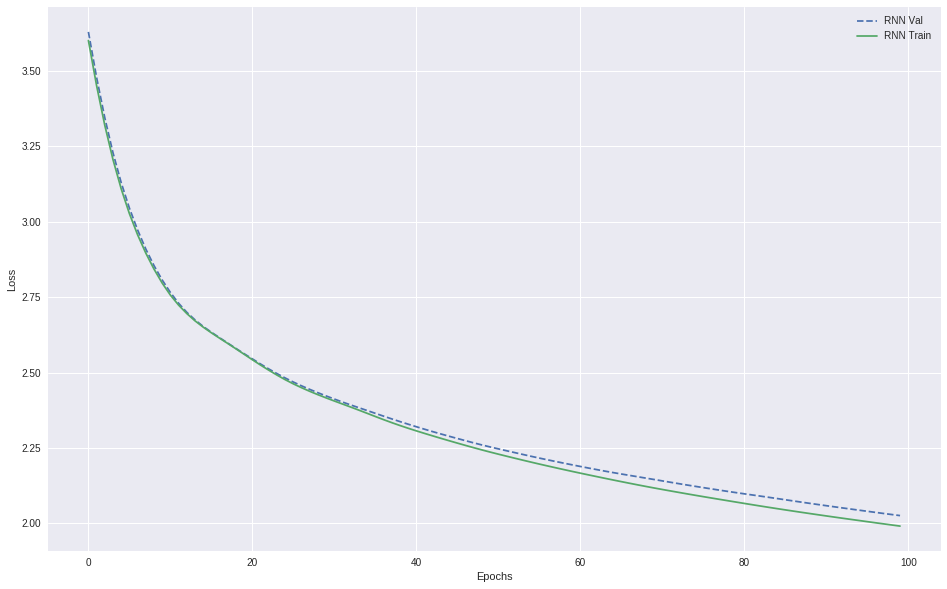

In [0]:
plt.figure(figsize=(16,10))
    
plt.plot(epochs, val_loss, '--', label='RNN Val')
plt.plot(epochs, train_loss, '-g', label='RNN Train')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [0]:
# Try RNN LSTM model from paper using Keras

In [0]:
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [0]:
labels_onehot = one_hot_encode(labels)

In [0]:
from sklearn.model_selection import train_test_split

# X_train, X_tstv, y_train, y_tstv = train_test_split(audio_features, labels, test_size=0.2)

X_train, X_tstv, y_train, y_tstv = train_test_split(audio_features, labels_onehot, test_size=0.2)

X_val, X_test, y_val, y_test = train_test_split(X_tstv, y_tstv, test_size=0.2)

In [0]:
# LSTM architecture devised by Dr. Jason Collins (https://github.com/jaron/deep-listening/blob/master/7-us8k-rnn-extract-train.ipynb)

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

data_dim = 41
timesteps = 20
num_classes = 19

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()

# returns a sequence of vectors of dimension 256
model.add(LSTM(512, return_sequences=True, input_shape=(timesteps, data_dim)))  
model.add(Dropout(0.15))

# returns a sequence of vectors of dimension 256
model.add(LSTM(512, return_sequences=True))  
model.add(Dropout(0.25))

# return a single vector of dimension 128
model.add(LSTM(256))  
model.add(Dropout(0.35))

# apply softmax to output
model.add(Dense(num_classes, activation='softmax'))

# compile the model for multi-class classification
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# a stopping function to stop training before we excessively overfit to the training set
earlystop = EarlyStopping(monitor='val_loss', patience=0, verbose=1, mode='auto')
model_history = model.fit(X_train, y_train, batch_size=128, epochs=20, callbacks=[earlystop],validation_data=(X_val, y_val))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 59267 samples, validate on 11853 samples
Epoch 1/20
59267/59267 [==============================] - 92s 2ms/step - loss: 1.4426 - acc: 0.5734 - val_loss: 1.0942 - val_acc: 0.6684
Epoch 2/20
59267/59267 [==============================] - 87s 1ms/step - loss: 0.9395 - acc: 0.7209 - val_loss: 0.8117 - val_acc: 0.7543
Epoch 3/20
59267/59267 [==============================] - 87s 1ms/step - loss: 0.7347 - acc: 0.7798 - val_loss: 0.6665 - val_acc: 0.7990
Epoch 4/20
59267/59267 [==============================] - 87s 1ms/step - loss: 0.6117 - acc: 0.8163 - val_loss: 0.5251 - val_acc: 0.8389
Epoch 5/20
59267/59267 [==============================] - 86s 1ms/step - loss: 0.5048 - acc: 0.8464 - val_loss: 0.4807 - val_acc: 0.8546
Epoch 6/20
59267/59267 [======

In [0]:
def plot_history(histories, key='loss'):
  plt.figure(figsize=(16,10))
    
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])
  
  plt.show()
  


In [0]:
model_history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

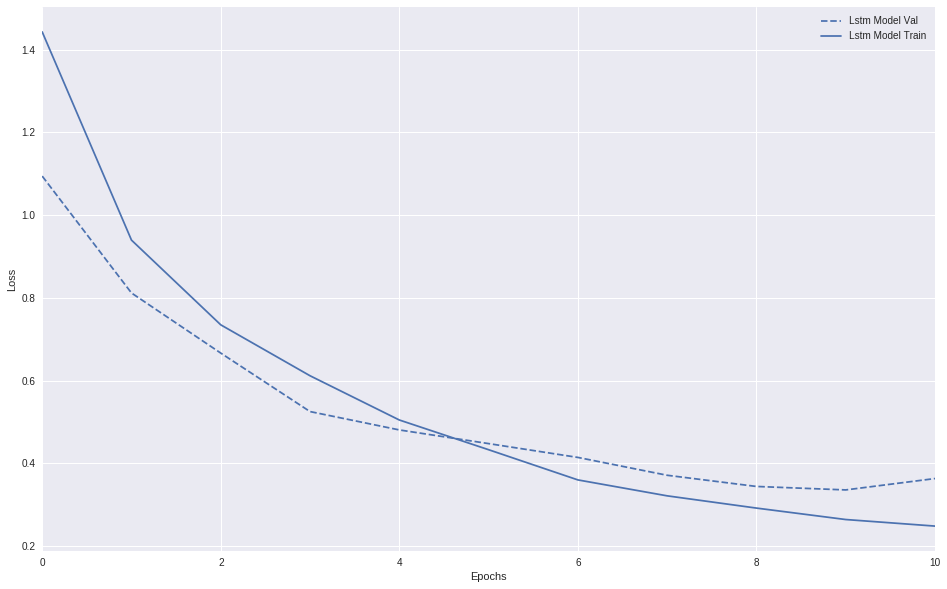

In [0]:
plot_history([('LSTM model', model_history)])

In [0]:
# Match species names to correct classification labels
species_names = ["Rose-crested Blue Pipit", "Blue-collared Zipper", "Bombadil", "Broad-winged Jojo", "Canadian Cootamum", 
                      "Carries Champagne Pipit", "Darkwing Sparrow", "Eastern Corn Skeet", "Green-tipped Scarlet Pipit", 
                      "Lesser Birchbeere", "Orange Pine Plover", "Ordinary Snape", "Pinkfinch", "Purple Tooting Tout", 
                      "Qax", "Queenscoat", "Bent-beak Riffraff", "Scrawny Jay", "Vermillion Trillian"]

model_prediction_species = []

for oneHot in y_test:
    uniqueValues, uniqueIndexes = np.unique(oneHot, return_index=True)
    
    model_prediction_species.append(species_names[uniqueIndexes[1]])
    #print ("Index: " + str(index) + " | " + species_names[index])

In [0]:
prediction_features = []
prediction_features=X_test # For later use in 'Test Model' section


In [0]:
# Create predictions for each of the sound classes

# Variables used to calculate correct percentanges 
total_correct = 0
correct_by_species = []
species_correct = 0;
species_total = 0;
current_species = "Rose-crested Blue Pipit"

# Loop over each feature set from test data
for s in range(len(model_prediction_species)):
    
    # Handles correct percentages per species
    if (current_species != model_prediction_species[s]):
        percent = float(species_correct) / species_total
        correct_by_species.append(str(current_species) + ": " + str(percent) + " (" + str(species_correct) + "/" + str(species_total) + ")")
        species_correct = 0
        species_total = 0
        
    # Grab ground truth for current feature set to be tested against
    current_species = model_prediction_species[s]
    #print ("\n----- ", current_species, "-----")
    
    # Load prediction_features for current_species
    predict_x = prediction_features[s]
    predict_x = np.expand_dims(predict_x, axis=0)
    predictions = model.predict(predict_x)

    # If no prediction was able to be generated, print so
    if len(predictions) == 0: 
        print ("No prediction")
    
    # If not, print the top 3 guesses
    ind = predictions[0].argsort()[-3:][::-1]
    #print ("Top guess: ", species_names[ind[0]], " (",round(predictions[0,ind[0]],3),")")
    #print ("2nd guess: ", species_names[ind[1]], " (",round(predictions[0,ind[1]],3),")")
    #print ("3rd guess: ", species_names[ind[2]], " (",round(predictions[0,ind[2]],3),")")
    
    # Accumulate number of correct guesses for percentage calculations
    if (species_names[ind[0]] == current_species):
        total_correct += 1
        species_correct += 1
    species_total += 1

# Print final results
percentCorrect = (float(total_correct) / len(model_prediction_species))
print ("\n----- Percent correct -----")
print (percentCorrect)
print (correct_by_species)
for i in correct_by_species: # Print out the percentage correct for each classifier
    print(i)

In [0]:
test_features = np.load('/content/gdrive/My Drive/Colab Notebooks/test_features.npy')

In [0]:
test_refs = np.load('/content/gdrive/My Drive/Colab Notebooks/test_refs.npy')

In [0]:
predictions = model.predict(test_features)

In [0]:
tmp=np.sum(predictions[test_refs=='7.mp3'], axis=0)

In [0]:
int(np.where(tmp==max(tmp))[0])

17

In [0]:
kasios_classifications=list()

for i in np.unique(test_refs):
  sum = np.sum(predictions[test_refs==i], axis=0)
  prediction = int(np.where(sum==max(sum))[0])
  prediction = species_names[prediction]
  kasios_classifications.append((i, prediction))
                        

In [0]:
kasios_classifications

[('1.mp3', 'Broad-winged Jojo'),
 ('10.mp3', 'Orange Pine Plover'),
 ('11.mp3', 'Bombadil'),
 ('12.mp3', 'Orange Pine Plover'),
 ('13.mp3', 'Rose-crested Blue Pipit'),
 ('14.mp3', 'Darkwing Sparrow'),
 ('15.mp3', 'Bent-beak Riffraff'),
 ('2.mp3', 'Rose-crested Blue Pipit'),
 ('3.mp3', 'Bombadil'),
 ('4.mp3', 'Bombadil'),
 ('5.mp3', 'Bombadil'),
 ('6.mp3', 'Green-tipped Scarlet Pipit'),
 ('7.mp3', 'Scrawny Jay'),
 ('8.mp3', 'Lesser Birchbeere'),
 ('9.mp3', 'Rose-crested Blue Pipit')]

In [0]:
np.save('/content/gdrive/My Drive/Colab Notebooks/kasios_classifications.npy', kasios_classifications)

# Plots and spectra

In [0]:
librosa.display.waveplot(audio_data[4][0], sr)

In [0]:
ipd.Audio(audio_data[3][0], rate=sr)

In [0]:
librosa.display.waveplot(audio, sr)

In [0]:
ipd.Audio(audio, rate=sr)

In [0]:
pow_melspec = librosa.feature.melspectrogram(audio, sr, power=2.0)

In [0]:
db_melspec=librosa.power_to_db(pow_melspec)
plt.figure(figsize=(10, 4))
librosa.display.specshow(db_melspec, x_axis='time')
plt.colorbar()


In [0]:
# split to 30s segments with x% (read papers) overlapping via indexing; for final window when index is > len, take [:-30]